<a href="https://colab.research.google.com/github/shivendrra/NLP-Projects/blob/main/DemoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vector_data.csv to vector_data.csv


In [ ]:
file_name = list(uploaded.keys())[0]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time

start_time = time.time()
# Define CustomDataset
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'input': torch.FloatTensor(self.data.iloc[idx, :-1].values),
                  'target': torch.FloatTensor([self.data.iloc[idx, -1]])}
        return sample

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)

        # Reshape x to have shape (sequence_length, batch_size, d_model)
        x = x.unsqueeze(0)  # Add a sequence dimension at the beginning

        # Apply transformer
        x = self.transformer(x, x)

        # Remove the sequence dimension
        x = x.squeeze(0)

        # Average over the sequence dimension
        x = torch.mean(x, dim=0)

        # Pass through the fully connected layer
        x = self.fc(x)
        return x

# Initialize dataset and DataLoader
dataset = CustomDataset('vector_data.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
input_size = dataset[0]['input'].shape[0]
output_size = dataset[0]['target'].shape[0]
model = TransformerModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 11
losses = []  # List to store the losses

for epoch in range(num_epochs):
    epoch_losses = []  # List to store the losses for each epoch

    for batch in dataloader:
        inputs, targets = batch['input'], batch['target']

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_epoch_loss = np.mean(epoch_losses)
    losses.append(average_epoch_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_epoch_loss}')

end_time = start_time - time.time()
print('\n', f"Code executed in {end_time / 60} mins")
# Save the trained model
torch.save(model.state_dict(), 'transformer_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/11, Loss: 0.004114814102649689
Epoch 2/11, Loss: 5.622119426727295
Epoch 3/11, Loss: 0.4075750410556793
Epoch 4/11, Loss: 0.12809598445892334
Epoch 5/11, Loss: 0.2046448290348053
Epoch 6/11, Loss: 0.15502487123012543
Epoch 7/11, Loss: 0.055153459310531616
Epoch 8/11, Loss: 0.07814256101846695
Epoch 9/11, Loss: 0.027688810601830482
Epoch 10/11, Loss: 0.018990226089954376
Epoch 11/11, Loss: 0.019615348428487778

 Code executed in -0.057789989312489826 mins


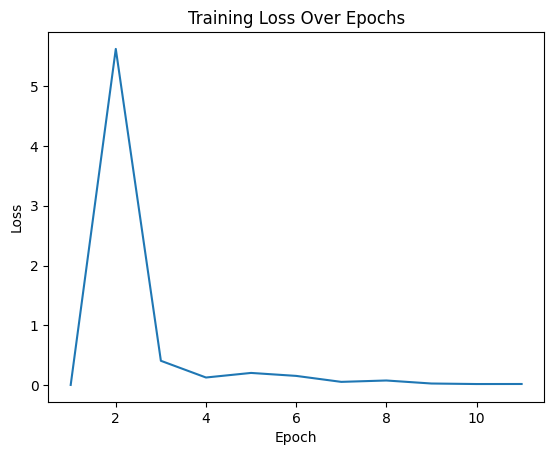

In [ ]:
import matplotlib.pyplot as plt
# Visualize training loss
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False)
plt.show()